<a href="https://colab.research.google.com/github/gaxler/transmotion/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone Repo, Install reqs & download weights

In [12]:
!git clone https://github.com/gaxler/transmotion.git
!pip install -r /content/transmotion/requirements.txt
!pip install einops
!pip install --upgrade imageio[ffmpeg]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [1]:
import sys
import os
os.chdir('/content/transmotion/src')

In [2]:
!wget -c https://cloud.tsinghua.edu.cn/f/da8d61d012014b12a9e4/?dl=1 -O /content/transmotion/vox.pth.tar

--2022-10-29 04:34:08--  https://cloud.tsinghua.edu.cn/f/da8d61d012014b12a9e4/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 166.111.6.101, 2402:f000:1:406:166:111:6:101
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|166.111.6.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/8f6867a4-1fee-404f-921e-929a92b9f622/vox.pth.tar [following]
--2022-10-29 04:34:09--  https://cloud.tsinghua.edu.cn/seafhttp/files/8f6867a4-1fee-404f-921e-929a92b9f622/vox.pth.tar
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 206 Partial Content
Length: 350993469 (335M), 325447997 (310M) remaining [application/octet-stream]
Saving to: ‘/content/transmotion/vox.pth.tar’

/content/transmotio 100%[+==================>] 334.73M  15.9MB/s    in 21s     

2022-10-29 04:34:30 (14.5 MB/s) - ‘/content/transmotion/vox.pth.tar’ saved [350993469/350993469]



## Model Config & Pretrained Loading

In [5]:
import torch as th
import torch.nn.functional as F
import torchvision

from transmotion.configs import dummy_conf
from transmotion.weights import import_state_dict


from demo_helpers import pretrained_weights_to_model_cls

DEVICE_NAME = "cuda:0" if th.cuda.device_count() > 0 else "cpu"
DEVICE = th.device(DEVICE_NAME)

conf = dummy_conf()
IMAGE_SIZE = conf.image_size

# dict mapping weights to module that needs them
weights_for = pretrained_weights_to_model_cls("../vox.pth.tar")

def load_orig_weights_to_device(net: th.nn.Module) -> th.nn.Module:
    net_cls = net.__class__
    pretrained_w = import_state_dict(weights_for[net_cls], net.state_dict())
    net.load_state_dict(pretrained_w)
    return net.to(DEVICE)


## Draw Key-Points

### Load Key Point Detector

In [8]:
from transmotion.kp_detection import KPDetector, KPResult

kp_detector = KPDetector(conf.tps)
kp_detector = load_orig_weights_to_device(kp_detector)

### Predict Key-Points for image

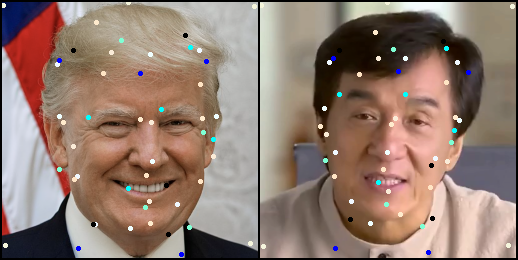

In [13]:

from transmotion.viz import show_points_on_grid
from transmotion.weights import import_state_dict

from demo_helpers import src_img_tensor, drv_vid_tensor


src_img_t = src_img_tensor(img_size=IMAGE_SIZE).to(DEVICE)
drv_vid_t = drv_vid_tensor(img_size=IMAGE_SIZE).to(DEVICE) 

## Just for show
img_batch = th.cat((src_img_t, drv_vid_t[:1]), dim=0)
with th.no_grad():
    kp_src_drv_init: KPResult
    kp_src_drv_init = kp_detector(img_batch)
# kp_drv_init = kp_detector(drv_vid_t[0]) 
show_points_on_grid(img_batch, kp_src_drv_init)


## Infer Optical Flow 

### Load Dense Motion Network

In [14]:
from transmotion.dense_motion import DenseMotionNetwork, DenseMotionResult

dense_motion = DenseMotionNetwork(cfg=conf.dense_motion)
dense_motion = load_orig_weights_to_device(dense_motion)

### Normalize Keypoints

In [15]:
with th.no_grad():
    kp_src: KPResult
    kp_src = kp_detector(src_img_t)
    kp_drv_init: KPResult
    kp_drv_init = kp_detector(drv_vid_t[:1])

Now that we have the source and initial driving key-points, we build a dense motion inference function.

This function normalizes key points of current driving frame and passes the normalized key points thorugh the dense motion detector

In [18]:
def dense_infer_normalized_kp(drv_img: th.Tensor) -> DenseMotionResult:
    kp_drv: KPResult
    kp_drv = kp_detector(drv_img.unsqueeze(0))
    kp_norm = kp_src.normalize_relative_to(init_=kp_drv_init, cur_=kp_drv)
    
    motion_res = dense_motion(
            source_img=src_img_t,
            src_kp=kp_src,
            drv_kp=kp_norm,
            bg_param=None,
            dropout_prob=0.0,
        )
    return motion_res

## Visualize Dense Motion Results

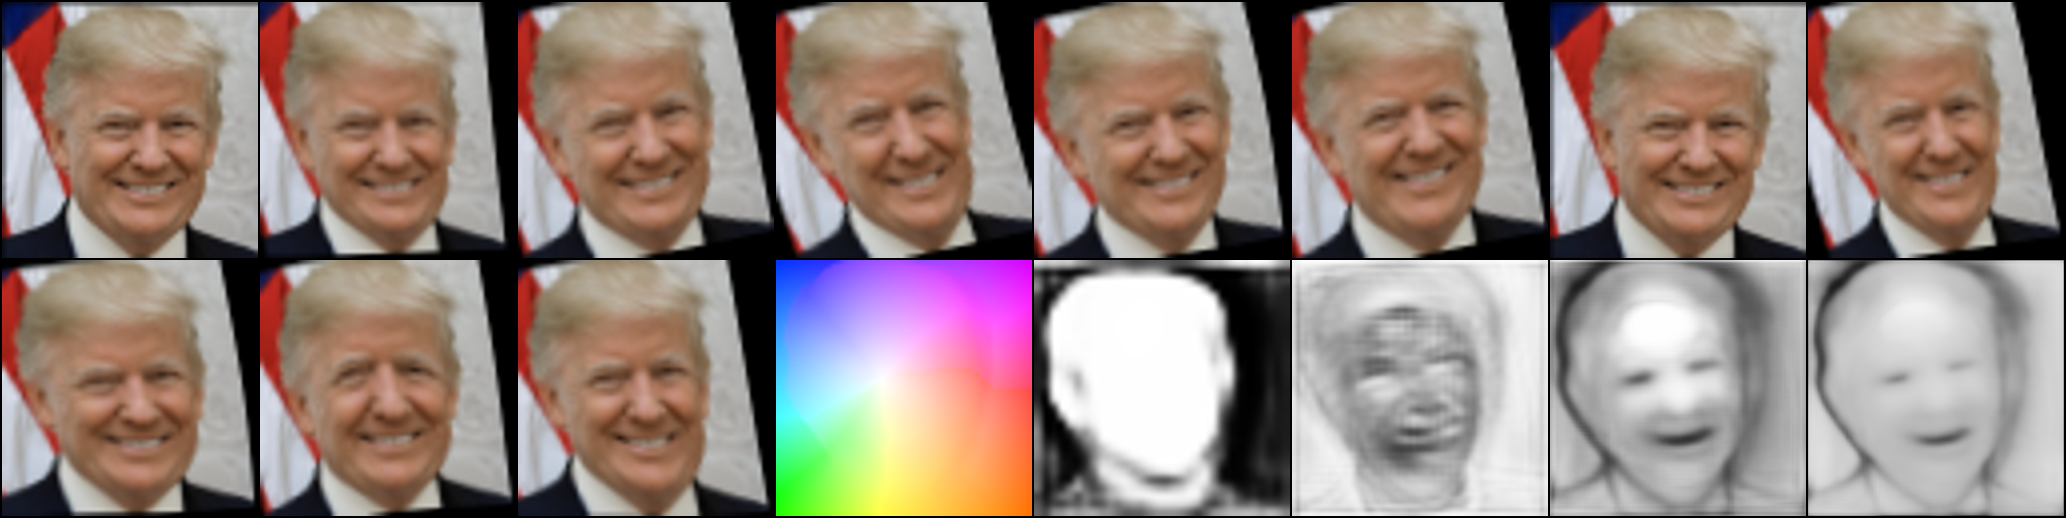

In [19]:
from transmotion.viz import show_on_gird
from demo_helpers import pils_to_grid, tensors_to_pils, optical_flow_pil 

with th.no_grad():
    res = dense_infer_normalized_kp(drv_vid_t[20])


sparse_deformations = tensors_to_pils(*res.deformed_source[0])
optical_flow = optical_flow_pil(res.optical_flow, size=IMAGE_SIZE)
# Occlusion masks are 1D, we need to turn them into 3D so that they can be on the same grid with everything else
occlusion_masks = [pim.convert("RGB") for pim in tensors_to_pils(*res.occlusion_masks, size=IMAGE_SIZE)]

all_pils = sparse_deformations + [optical_flow] + occlusion_masks
pils_to_grid(*all_pils, size=IMAGE_SIZE)

This is how occluded images look like

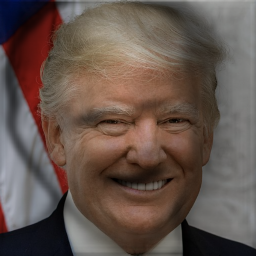

In [20]:
f = lambda x: F.interpolate(x, (256,256), mode="bilinear", align_corners=True)
tensors_to_pils(th.cat([f(x) for x in res.occlusion_masks[2:3]], dim=0).mean(0)*src_img_t)[0]

## Inpainting the occluded areas

In [21]:
from transmotion.inpainting import InpaintingNetwork, InpaintingResult

inpaint = InpaintingNetwork(cfg=conf.inpainting)
inpaint = load_orig_weights_to_device(inpaint)

In [22]:
inpaint_res: InpaintingResult
inpaint_res = inpaint(
    source_img=src_img_t,
    occlusion_masks=res.occlusion_masks,
    optical_flow=res.optical_flow,
)


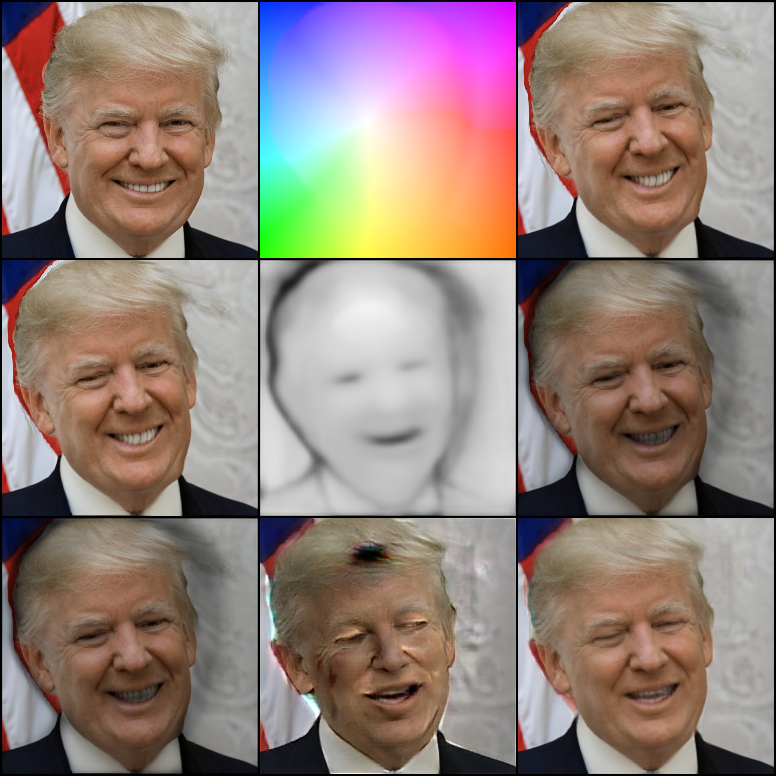

In [23]:
from demo_helpers import pil_to_t

broadcaster_occlusion =res.occlusion_masks[-1].repeat(1,3,1,1) 
inv_occlusion = (1 - broadcaster_occlusion)
residual_prediction = (inpaint_res.inpainted_img - inpaint_res.deformed_source*broadcaster_occlusion) / inv_occlusion
occluded_deformed_img = inpaint_res.deformed_source*broadcaster_occlusion

# source, optical flow, deformed
row1 = (src_img_t, pil_to_t(optical_flow).unsqueeze(0), inpaint_res.deformed_source)
# deformed, occlusion, occluded deformed
row2 = (inpaint_res.deformed_source, broadcaster_occlusion, occluded_deformed_img)
# occluded deformed, predicted inpainting, final prediction
row3 = (occluded_deformed_img, residual_prediction, inpaint_res.inpainted_img)

show_on_gird(*(row1+row2+row3), nrow=3)


## Generating Animation

In [ ]:
import imageio
from einops import rearrange
from transmotion.network_bundle import NetworksBundle, get_kp_normalized_forward_func
from skimage import img_as_ubyte
from tqdm import tqdm

nets = NetworksBundle(
    key_points=kp_detector, 
    dense_motion=dense_motion, 
    inpaint=inpaint, 
    background_motion=None
).eval()


predictions = []
drv_frame_infer_fn = None
for idx, drv_img in tqdm(enumerate(drv_vid_t)):
if drv_frame_infer_fn is None:
    drv_frame_infer_fn = get_kp_normalized_forward_func(
        src_img=src_img_t,
        intial_drv_img=drv_img.unsqueeze(0),
        nets=nets,
    )
res = drv_frame_infer_fn(drv_img.unsqueeze(0))

gen_frame = rearrange(res.generated_image, "b d h w -> b h w d").squeeze(0)
drv_frame = rearrange(drv_img, "d h w -> h w d")
frame = th.cat([gen_frame, drv_frame], dim=1)
predictions.append(frame.numpy())

out_path = "/content/transmotion/static/out.gif"
imageio.mimsave(out_path, [img_as_ubyte(f) for f in predictions], fps=25)